# Reproduction study - DECAF: Generating Fair Synthetic Data Using Causally-Aware Generative Networks

This notebook can be used to run the experiments as described in our report. Note that this notebook uses pretrained models.

In [1]:
from pyparsing import col
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import statistics
import pickle

from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from util import data, metrics, adult_data, credit_data, plots
from model.DECAF import DECAF

C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")
c:\python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


## Experiment 1 - Debiasing Census Data

First, load the adult data, the DAG and the biased edges for different fairness definitions.

In [2]:
dfr, Xy, min_max_scaler = adult_data.load()
X = Xy[:, :-1]
y = np.round(Xy[:, -1]).astype(int)
dm = data.DataModule(Xy)

dag_seed = [
        [0, 6],
        [0, 12],
        [0, 14],
        [0, 1],
        [0, 5],
        [0, 3],
        [1, 14],
        [3, 6],
        [3, 12],
        [3, 14],
        [3, 1],
        [3, 7],
        [5, 6],
        [5, 12],
        [5, 14],
        [5, 1],
        [5, 7],
        [5, 3],
        [6, 14],
        [7, 14],
        [8, 6],
        [8, 14],
        [8, 12],
        [8, 3],
        [8, 5],
        [9, 6],
        [9, 5],
        [9, 14],
        [9, 12],
        [9, 1],
        [9, 3],
        [9, 7],
        [12, 14],
        [13, 5],
        [13, 12],
        [13, 3],
        [13, 1],
        [13, 14],
        [13, 7],
    ]
bias_dict_FTU = {14: [9]}
bias_dict_CF = {14: [7, 9, 5]}
bias_dict_DP = {14: [7, 13, 1, 9, 5, 12, 6]}

In [3]:
original_data = {
    "precision": [],
    "recall": [],
    "auroc": [],
    "FTU": [],
    "DP": []
}
GAN = {
    "precision": [],
    "recall": [],
    "auroc": [],
    "FTU": [],
    "DP": []
}
WGAN_GP = {
    "precision": [],
    "recall": [],
    "auroc": [],
    "FTU": [],
    "DP": []
}
GAN_PR = {
    "precision": [],
    "recall": [],
    "auroc": [],
    "FTU": [],
    "DP": []
}
WGAN_GP_PR = {
    "precision": [],
    "recall": [],
    "auroc": [],
    "FTU": [],
    "DP": []
}
DECAF_ND = {
    "precision": [],
    "recall": [],
    "auroc": [],
    "FTU": [],
    "DP": []
}
DECAF_FTU = {
    "precision": [],
    "recall": [],
    "auroc": [],
    "FTU": [],
    "DP": []
}
DECAF_CF = {
    "precision": [],
    "recall": [],
    "auroc": [],
    "FTU": [],
    "DP": []
}
DECAF_DP = {
    "precision": [],
    "recall": [],
    "auroc": [],
    "FTU": [],
    "DP": []
}

def calculate_scores(Xy_synth, model_type):
    ## Takes Xy_synthetic data (including label) of the adult data set and model type
    ## Calculates the precision, recall, auroc, FTU and DP metrics
    X_synth = Xy_synth[:, :-1]
#     print("nan in X_synth", np.isnan(X_synth).any())
    y_synth = np.round(Xy_synth[:, -1]).astype(int)
#     print("nan in y_synth", np.isnan(y_synth).any())    
    
    synth_clf = MLPClassifier(max_iter=2000).fit(X_synth, y_synth)
    y_pred_synth = synth_clf.predict(X)
#     print("nan in y_pred_synth", np.isnan(y_pred_synth).any())
    y_pred_synth_proba = synth_clf.predict_proba(X)
#     print("nan in y_pred_synth_proba", np.isnan(y_pred_synth_proba).any())
    
    if model_type == "original":
        original_data["precision"].append(precision_score(y, y_pred_synth))
        original_data["recall"].append(recall_score(y, y_pred_synth))
        original_data["auroc"].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        original_data["FTU"].append(metrics.ftu(synth_clf, X_synth, 9))
        original_data["DP"].append(metrics.dp(synth_clf, X_synth, 9))
    elif model_type == "GAN":
        GAN["precision"].append(precision_score(y, y_pred_synth))
        GAN["recall"].append(recall_score(y, y_pred_synth))
        GAN["auroc"].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        GAN["FTU"].append(metrics.ftu(synth_clf, X_synth, 9))
        GAN["DP"].append(metrics.dp(synth_clf, X_synth, 9))
    elif model_type == "WGAN_GP":
        WGAN_GP["precision"].append(precision_score(y, y_pred_synth))
        WGAN_GP["recall"].append(recall_score(y, y_pred_synth))
        WGAN_GP["auroc"].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        WGAN_GP["FTU"].append(metrics.ftu(synth_clf, X_synth, 9))
        WGAN_GP["DP"].append(metrics.dp(synth_clf, X_synth, 9))    
    elif model_type == "GAN_PR":
        GAN_PR["precision"].append(precision_score(y, y_pred_synth))
        GAN_PR["recall"].append(recall_score(y, y_pred_synth))
        GAN_PR["auroc"].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        GAN_PR["FTU"].append(metrics.ftu(synth_clf, X_synth, 9))
        GAN_PR["DP"].append(metrics.dp(synth_clf, X_synth, 9))
    elif model_type == "WGAN_GP_PR":
        WGAN_GP_PR["precision"].append(precision_score(y, y_pred_synth))
        WGAN_GP_PR["recall"].append(recall_score(y, y_pred_synth))
        WGAN_GP_PR["auroc"].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        WGAN_GP_PR["FTU"].append(metrics.ftu(synth_clf, X_synth, 9))
        WGAN_GP_PR["DP"].append(metrics.dp(synth_clf, X_synth, 9))            
    elif model_type == "ND":
        DECAF_ND["precision"].append(precision_score(y, y_pred_synth))
        DECAF_ND["recall"].append(recall_score(y, y_pred_synth))
        DECAF_ND["auroc"].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        DECAF_ND["FTU"].append(metrics.ftu(synth_clf, X_synth, 9))
        DECAF_ND["DP"].append(metrics.dp(synth_clf, X_synth, 9))
    elif model_type == "FTU":
        DECAF_FTU["precision"].append(precision_score(y, y_pred_synth))
        DECAF_FTU["recall"].append(recall_score(y, y_pred_synth))
        DECAF_FTU["auroc"].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        DECAF_FTU["FTU"].append(metrics.ftu(synth_clf, X_synth, 9))
        DECAF_FTU["DP"].append(metrics.dp(synth_clf, X_synth, 9))
    elif model_type == "CF":
        DECAF_CF["precision"].append(precision_score(y, y_pred_synth))
        DECAF_CF["recall"].append(recall_score(y, y_pred_synth))
        DECAF_CF["auroc"].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        DECAF_CF["FTU"].append(metrics.ftu(synth_clf, X_synth, 9))
        DECAF_CF["DP"].append(metrics.dp(synth_clf, X_synth, 9))    
    elif model_type == "DP":
        DECAF_DP["precision"].append(precision_score(y, y_pred_synth))
#         print("precision done")
        DECAF_DP["recall"].append(recall_score(y, y_pred_synth))
#         print("recall done")
        DECAF_DP["auroc"].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
#         print("auroc done")
        DECAF_DP["FTU"].append(metrics.ftu(synth_clf, X_synth, 9))
#         print("ftu done")
        DECAF_DP["DP"].append(metrics.dp(synth_clf, X_synth, 9))
#         print("dp done")
    else:
        print("Warning: model_type not recognized")
    return

If you would like to generate the synthetic data from the pre-trained models yourself, run the cell below. This will take approximately 1 hour for the 10 models (UPDATE THIS NUMBER). Otherwise, run the second cell.

In [4]:
# Run if you want to generate synthetic data yourself. Otherwise, skip this cell.

# models = ["logs/DECAF_adult/version_0/checkpoints/epoch=49-step=21249.ckpt","logs/DECAF_adult/version_1/checkpoints/epoch=49-step=21249.ckpt" ]
models = ["logs/DECAF_adult/version_0/checkpoints/epoch=49-step=21249.ckpt", "logs/DECAF_adult/version_1/checkpoints/epoch=49-step=21249.ckpt", "logs/DECAF_adult/version_2/checkpoints/epoch=49-step=21249.ckpt", "logs/DECAF_adult/version_3/checkpoints/epoch=49-step=21249.ckpt", "logs/DECAF_adult/version_4/checkpoints/epoch=49-step=21249.ckpt", "logs/DECAF_adult/version_5/checkpoints/epoch=49-step=21249.ckpt", "logs/DECAF_adult/version_6/checkpoints/epoch=49-step=21249.ckpt", "logs/DECAF_adult/version_7/checkpoints/epoch=49-step=21249.ckpt", "logs/DECAF_adult/version_8/checkpoints/epoch=49-step=21249.ckpt", "logs/DECAF_adult/version_9/checkpoints/epoch=49-step=21249.ckpt"] # to be added

# data_all_models = [] # delete if file generated date already exists

# calculate scores baseline
for i in range(10):
    calculate_scores(Xy, model_type="original")
print("scores original data calculated")

# for trained_model in models:
#     print("new model being evaluated")
for i in range(10):
    model = DECAF(input_dim=dm.dims[0])
    trained_model = "logs/DECAF_adult/version_{}/checkpoints/epoch=49-step=21249.ckpt".format(i)
    model = model.load_from_checkpoint(trained_model)
    
    synthetic_data = model.gen_synthetic(dm.dataset.x, gen_order=model.get_gen_order(), biased_edges={}).detach().numpy()
    calculate_scores(synthetic_data, model_type="ND")
    
    synthetic_data_FTU = model.gen_synthetic(dm.dataset.x, gen_order=model.get_gen_order(), biased_edges=bias_dict_FTU).detach().numpy()
    calculate_scores(synthetic_data_FTU, model_type="FTU")
    
    synthetic_data_CF = model.gen_synthetic(dm.dataset.x, gen_order=model.get_gen_order(), biased_edges=bias_dict_CF).detach().numpy()
    calculate_scores(synthetic_data_CF, model_type="CF")
    
    synthetic_data_DP = model.gen_synthetic(dm.dataset.x, gen_order=model.get_gen_order(), biased_edges=bias_dict_DP).detach().numpy()    
    calculate_scores(synthetic_data_DP, model_type="DP")
    
    print("model {} is trained".format(i))
    
#     synthetic_data_to_store = {}        
#     synthetic_data_to_store["synthetic_data"] = synthetic_data
#     synthetic_data_to_store["synthetic_data_FTU"] = synthetic_data_FTU
#     synthetic_data_to_store["synthetic_data_CF"] = synthetic_data_CF
#     synthetic_data_to_store["synthetic_data_DP"] = synthetic_data_DP
    
#     data_all_models.append(synthetic_data_to_store)
    
# with open('synthetic_data.pkl', 'wb') as f:
#     pickle.dump(data_all_models, f)


model 0 is trained
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        

model 8 is trained
Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        

In [41]:
# Run if you want to use pre-generated synthetic data

with open('synthetic_data.pkl', 'rb') as f:
    all_syn_data = pickle.load(f)

for synthetic_data_stored in all_syn_data:
    synthetic_data = synthetic_data_stored["synthetic_data"]
    calculate_scores(synthetic_data, model_type="ND")
    synthetic_data_FTU = synthetic_data_stored["synthetic_data_FTU"]
    calculate_scores(synthetic_data_FTU, model_type="FTU")
    synthetic_data_CF = synthetic_data_stored["synthetic_data_CF"]
    calculate_scores(synthetic_data_CF, model_type="CF")
    synthetic_data_DP = synthetic_data_stored["synthetic_data_DP"]
    calculate_scores(synthetic_data_DP, model_type="DP")


In [5]:
def calc_metrics(data):
    # Calculate mean and stdev of the data, returns a string
    mean = statistics.mean(data)
    stdev = statistics.stdev(data, mean)
    return "{:.3f}±{:.3f}".format(mean, stdev)
    
d = [ ["Original Data", calc_metrics(original_data["precision"]), calc_metrics(original_data["recall"]), calc_metrics(original_data["auroc"]), calc_metrics(original_data["FTU"]), calc_metrics(original_data["DP"])],
     ["GAN", 0 ,0,0,0,0],
     ["WGAN-GP", 0 ,0,0,0,0],
     ["GAN-PR", 0 ,0,0,0,0],
     ["WGAN-GP-PR", 0 ,0,0,0,0],
     ["DECAF-ND", calc_metrics(DECAF_ND["precision"]), calc_metrics(DECAF_ND["recall"]), calc_metrics(DECAF_ND["auroc"]), calc_metrics(DECAF_ND["FTU"]), calc_metrics(DECAF_ND["DP"])],
     ["DECAF-FTU", calc_metrics(DECAF_FTU["precision"]), calc_metrics(DECAF_FTU["recall"]), calc_metrics(DECAF_FTU["auroc"]), calc_metrics(DECAF_FTU["FTU"]), calc_metrics(DECAF_FTU["DP"])],
     ["DECAF-CF", calc_metrics(DECAF_CF["precision"]), calc_metrics(DECAF_CF["recall"]), calc_metrics(DECAF_CF["auroc"]), calc_metrics(DECAF_CF["FTU"]), calc_metrics(DECAF_CF["DP"])],
     ["DECAF-DP", calc_metrics(DECAF_DP["precision"]), calc_metrics(DECAF_DP["recall"]), calc_metrics(DECAF_DP["auroc"]), calc_metrics(DECAF_DP["FTU"]), calc_metrics(DECAF_DP["DP"])]
]

df = pd.DataFrame(d, columns = ["Model", "Precision", "Recall", "AUROC", "FTU", "DP"])
df

,Model,Precision,Recall,AUROC,FTU,DP
0,Original Data,0.880±0.008,0.933±0.011,0.915±0.003,0.037±0.014,0.197±0.012
1,GAN,0,0,0,0,0
2,WGAN-GP,0,0,0,0,0
3,GAN-PR,0,0,0,0,0
4,WGAN-GP-PR,0,0,0,0,0
5,DECAF-ND,0.805±0.019,0.903±0.040,0.799±0.009,0.057±0.018,0.176±0.019
6,DECAF-FTU,0.792±0.020,0.921±0.036,0.794±0.009,0.013±0.008,0.123±0.018
7,DECAF-CF,0.757±0.005,0.988±0.009,0.704±0.025,0.006±0.005,0.019±0.009
8,DECAF-DP,0.752±0.004,0.986±0.011,0.651±0.030,0.007±0.005,0.007±0.007


## Experiment 2 - Fair Credit Approval

First, load the credit data, the DAG and the biased edges for different fairness definitions of the credit data.

In [3]:
dfr, Xy, min_max_scaler = credit_data.load(0.5)
dm = data.DataModule(Xy)
X = Xy[:, :-1].astype("float32")
y = np.round(Xy[:, -1]).astype(int)

dag_seed = [[1, 7], [7, 10], [10, 2], [10, 15], [2, 14], [14, 15], [14, 3], [3, 15], [13, 3], [12, 3], [6, 3], [6, 15], [5, 3], [5, 9], [9, 2], [9, 15], [9, 4], [9, 12], [11, 9], [8, 10], [8, 15], [8, 9]]
bias_dict_credit_FTU = {15: [6]}
bias_dict_credit_DP = {15: [6, 3]}

n = 6
betas = np.linspace(0, 1, n, endpoint=True)

In [4]:
DECAF_Credit_ND = {
    "Precision": [[] for _ in range(len(betas))],
    "Recall": [[] for _ in range(len(betas))],
    "AUROC": [[] for _ in range(len(betas))],
    "FTU": [[] for _ in range(len(betas))],
    "DP": [[] for _ in range(len(betas))]
}
DECAF_Credit_FTU = {
    "Precision": [[] for _ in range(len(betas))],
    "Recall": [[] for _ in range(len(betas))],
    "AUROC": [[] for _ in range(len(betas))],
    "FTU": [[] for _ in range(len(betas))],
    "DP": [[] for _ in range(len(betas))]
}
DECAF_Credit_DP = {
    "Precision": [[] for _ in range(len(betas))],
    "Recall": [[] for _ in range(len(betas))],
    "AUROC": [[] for _ in range(len(betas))],
    "FTU": [[] for _ in range(len(betas))],
    "DP": [[] for _ in range(len(betas))]
}

In [5]:
def calculate_scores_credit(Xy_synth, fairness_type, beta_idx):
    ## Takes Xy_synthetic data (including label) of the adult data set and fairness type
    ## Calculates the precision, recall, auroc, FTU and DP metrics
    X_synth = Xy_synth[:, :-1]
    y_synth = np.round(Xy_synth[:, -1]).astype(int)   
    
    synth_clf = MLPClassifier().fit(X_synth, y_synth)
    y_pred_synth = synth_clf.predict(X)
    y_pred_synth_proba = synth_clf.predict_proba(X)
    print(beta_idx)
    
    if fairness_type == "ND":
        DECAF_Credit_ND["Precision"][beta_idx].append(precision_score(y, y_pred_synth))
        DECAF_Credit_ND["Recall"][beta_idx].append(recall_score(y, y_pred_synth))
        DECAF_Credit_ND["AUROC"][beta_idx].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        DECAF_Credit_ND["FTU"][beta_idx].append(metrics.ftu(synth_clf, X_synth, 6))
        DECAF_Credit_ND["DP"][beta_idx].append(metrics.dp(synth_clf, X_synth, 6))
    elif fairness_type == "FTU":
        DECAF_Credit_FTU["Precision"][beta_idx].append(precision_score(y, y_pred_synth))
        DECAF_Credit_FTU["Recall"][beta_idx].append(recall_score(y, y_pred_synth))
        DECAF_Credit_FTU["AUROC"][beta_idx].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        DECAF_Credit_FTU["FTU"][beta_idx].append(metrics.ftu(synth_clf, X_synth, 6))
        DECAF_Credit_FTU["DP"][beta_idx].append(metrics.dp(synth_clf, X_synth, 6))  
    elif fairness_type == "DP":
        DECAF_Credit_DP["Precision"][beta_idx].append(precision_score(y, y_pred_synth))
        DECAF_Credit_DP["Recall"][beta_idx].append(recall_score(y, y_pred_synth))
        DECAF_Credit_DP["AUROC"][beta_idx].append(roc_auc_score(y, y_pred_synth_proba[:, 1]))
        DECAF_Credit_DP["FTU"][beta_idx].append(metrics.ftu(synth_clf, X_synth, 6))
        DECAF_Credit_DP["DP"][beta_idx].append(metrics.dp(synth_clf, X_synth, 6))
    else:
        print("Warning: fairness_type not recognized")
    return

In [6]:
for idx, beta in enumerate(betas):
    models = []
    for i in range(10):
        models.append("logs/DECAF_credit{}/version_{}/checkpoints/epoch=249-step=2499.ckpt".format(beta, i)) # to be added

    for trained_model in models:
        model = DECAF(input_dim=dm.dims[0])    
        model = model.load_from_checkpoint(trained_model)

        synthetic_data = model.gen_synthetic(dm.dataset.x, gen_order=model.get_gen_order(), biased_edges={}).detach().numpy()
        calculate_scores_credit(synthetic_data, fairness_type="ND", beta_idx=idx)

        synthetic_data_FTU = model.gen_synthetic(dm.dataset.x, gen_order=model.get_gen_order(), biased_edges=bias_dict_credit_FTU).detach().numpy()
        calculate_scores_credit(synthetic_data_FTU, fairness_type="FTU", beta_idx=idx)

        synthetic_data_DP = model.gen_synthetic(dm.dataset.x, gen_order=model.get_gen_order(), biased_edges=bias_dict_credit_DP).detach().numpy()    
        calculate_scores_credit(synthetic_data_DP, fairness_type="DP", beta_idx=idx)

C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1
2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5
5


C:\Users\angela\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


ValueError: too many values to unpack (expected 1)

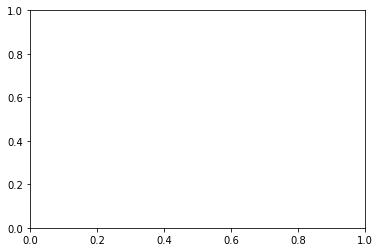

In [7]:
for metric in ["Precision", "Recall", "AUROC", "FTU", "DP"]:
    means_ND = [np.mean(data) for data in DECAF_Credit_ND[metric]]
    stds_ND = [np.std(data) for data in DECAF_Credit_ND[metric]]
    means_FTU = [np.mean(data) for data in DECAF_Credit_FTU[metric]]
    stds_FTU = [np.std(data) for data in DECAF_Credit_ND[metric]]
    means_DP = [np.mean(data) for data in DECAF_Credit_DP[metric]]
    stds_DP = [np.std(data) for data in DECAF_Credit_ND[metric]]
    results = {"DECAF-ND": list(zip(means_ND, stds_ND)),
                "DECAF-FTU": list(zip(means_FTU, stds_FTU)),
                "DECAF-DP": list(zip(means_DP, stds_DP))}
    plots.plot_errorbar(betas, metric, results)

# Extra experiments

## 1. Different DAG seed Experiment 1

## 2. Debiasing  Communities and Crime dataset